# Práctica 2 - No finalizado

Ahora es tu turno de construir un detector de objetos.

## Ejercicio obligatorio (5 puntos)

A continuación se listan una serie de datasets que están disponibles en Kaggle o en otras fuentes. El ejercicio que tenéis que realizar obligatoriamente consiste en elegir uno de esos datasets (también podéis elegir otro que vosotros prefiráis) y construir un modelo siguiendo las instrucciones proporcionadas en el notebook de instrucciones. Deberás completar los ejercicios planteados en el informe de prácticas, ten en cuenta que en los ejercicios planteados puedes tener que realizar algún cambio en el código proporcionado.

- [Kangaroo dataset](https://github.com/experiencor/kangaroo). En caso de utilizar este dataset tienes que eliminar la anotación y la imagen 00090 ya que está corrupta.
- [Racoon dataset](https://github.com/datitran/raccoon_dataset).
- [Wheat detection](https://www.kaggle.com/c/global-wheat-detection/data).
- [Winegrape Detection Dataset](https://github.com/thsant/wgisd).

También puedes elegir cualquiera de los datasets disponibles en [50+ Object Detection Datasets from different industry domains](https://towardsai.net/p/computer-vision/50-object-detection-datasets-from-different-industry-domains) o utilizar un dataset de otra fuente. **Ojo.** Cuidado con el tamaño de los datasets, si contienen muchas imágenes el proceso de entrenamiento puede ser muy largo.

## Ejercicios opcionales

A continuación se listan una serie de ejercicios adicionales. Para que estos ejercicios sean tenidos en cuenta han de ser documentadas en el propio notebook, dando una explicación de lo que se está haciendo. Debes crear un nuevo notebook para cada uno de los ejercicios que realices, completar los ejercicios planteados en el informe y guardarlo en este repositorio de GitHub.



HuggingFace no solo permite entrenar modelos con la arquitectura de YOLO sino también con otras muchas.
- Cambiar por otro modelo (1.5 puntos)
- *Ensemble* (1 punto). Una vez entrenados varios modelos crea un ensemble de los mismos para realizar predicciones. Para eliminar aquellos bounding boxes que se superpongan en la predicción usa la técnica de [Non maximum suppression](https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/).

Crea un space de HugginFace con el modelo que has creado (1 punto).

Además de la librería de HuggingFace existen otras librerías para entrenar modelos con arquitecturas que no están incluidas en HuggingFace. Elige una de las siguientes librerías y entrena un modelo con ella (1.5 punto):
- [FCOS](https://github.com/xuannianz/keras-fcos)
- [FSAF](https://github.com/xuannianz/FSAF)
- [YOLO v8](https://learnopencv.com/ultralytics-yolov8/)
- [YOLO v11](https://docs.ultralytics.com/es/models/yolo11/)

También puedes elegir otra librería que busques por tu cuenta con algún algoritmo que no esté disponible en las librerías anteriores.


Al finalizar, recuerda guardar los cambios en GitHub utilizando la opción Archivo -> Guardar una copia en GitHub.

# 0.0 Ejercicios Obligatórios

In [1]:
!pip install datasets

## 1.0 Dataset & Importación

In [2]:
import os
import json
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import albumentations
from datasets import Dataset, DatasetDict
from transformers import AutoImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer, pipeline
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import torchvision

In [3]:
%%capture
!git clone https://github.com/datitran/raccoon_dataset

In [4]:
path=Path('raccoon_dataset')
# Use iterdir() to list the contents of the directory
for item in path.iterdir():
    print(item)

raccoon_dataset/train
raccoon_dataset/split labels.ipynb
raccoon_dataset/generate_tfrecord.py
raccoon_dataset/__init__.py
raccoon_dataset/test_generate_tfrecord.py
raccoon_dataset/README.md
raccoon_dataset/draw boxes.ipynb
raccoon_dataset/LICENSE
raccoon_dataset/.git
raccoon_dataset/environment.yml
raccoon_dataset/test_xml_to_csv.py
raccoon_dataset/data
raccoon_dataset/xml_to_csv.py
raccoon_dataset/test
raccoon_dataset/images
raccoon_dataset/training
raccoon_dataset/annotations


In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
# Mapeamento de classes VOC->COCO
class_mapping = {"raccoon": 1}

def convert_voc_to_coco(voc_dir, coco_output_file):
    coco = {"images": [], "annotations": [], "categories": []}
    ann_id = 0
    xmls = list(Path(voc_dir).glob('*.xml'))
    for img_id, xml_file in enumerate(xmls):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        fn = root.findtext('filename')
        sz = root.find('size')
        w, h = int(sz.findtext('width')), int(sz.findtext('height'))
        coco["images"].append({"id": img_id, "file_name": fn, "width": w, "height": h})
        for obj in root.findall('object'):
            name = obj.findtext('name')
            b = obj.find('bndbox')
            xmin, ymin = int(b.findtext('xmin')), int(b.findtext('ymin'))
            xmax, ymax = int(b.findtext('xmax')), int(b.findtext('ymax'))
            bbox = [xmin, ymin, xmax-xmin, ymax-ymin]
            area = bbox[2] * bbox[3]
            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": class_mapping[name],
                "bbox": bbox,
                "area": area,
                "iscrowd": 0
            })
            ann_id += 1
    for nm, cid in class_mapping.items():
        coco["categories"].append({"id": cid, "name": nm})
    with open(coco_output_file, 'w') as f:
        json.dump(coco, f, indent=4)


In [7]:
# Generar JSONs COCO para train/test
convert_voc_to_coco('raccoon_dataset/train/annotations', 'raccoon_annotations_train.json')
convert_voc_to_coco('raccoon_dataset/test/annotations',  'raccoon_annotations_test.json')

Cargamos los archivos JSON para preprocesar los datos y crear el dataset.


In [8]:
def load_coco_dataset(image_dir, ann_file):
    with open(ann_file) as f:
        coco = json.load(f)
    imgs = {img['id']: img for img in coco['images']}
    an_by_img = {}
    for ann in coco['annotations']:
        an_by_img.setdefault(ann['image_id'], []).append(ann)
    data = []
    for img_id, info in imgs.items():
        data.append({
            'image': os.path.join(image_dir, info['file_name']),
            'objects': an_by_img.get(img_id, []),
            'image_id': img_id
        })
    return Dataset.from_list(data)

train_ds = load_coco_dataset('raccoon_dataset/train/images', 'raccoon_annotations_train.json')
test_ds  = load_coco_dataset('raccoon_dataset/test/images',  'raccoon_annotations_test.json')
dataset  = DatasetDict({'train': train_ds, 'test': test_ds})


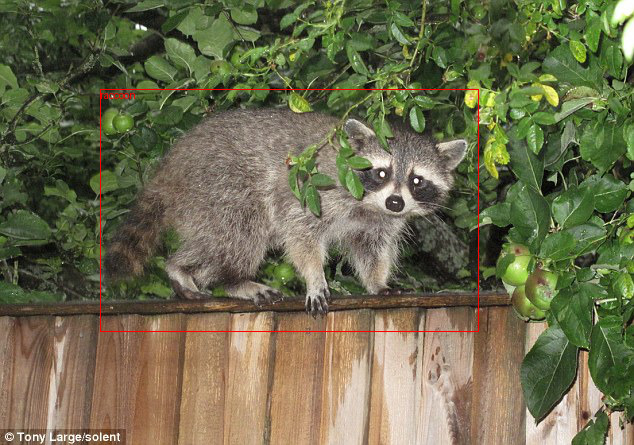

In [28]:
from PIL import Image, ImageDraw
image_path = dataset["train"][0]["image"]
image = Image.open(image_path)
annotations = dataset["train"][0]["objects"]
draw = ImageDraw.Draw(image)

id2label = {index: x for index, x in enumerate(class_mapping, start=0)}
label2id = {v: k for k, v in id2label.items()}

bboxes = [x['bbox'] for x in annotations]
category = [x['category_id'] for x in annotations]
area = [x['area'] for x in annotations]

for i in range(len(category)):
    box = bboxes[i - 1]
    class_idx = category[i - 1]
    x, y, w, h = tuple(box)
    class_name = list(class_mapping.keys())[list(class_mapping.values()).index(class_idx)]
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), class_name, fill="red")

image

### Transforms


In [9]:
train_transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.5),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['category_id']))

val_transform = albumentations.Compose([
    albumentations.Resize(480, 480),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['category_id']))


### Dataset personalizado


In [10]:
import torchvision

class RaccoonDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor, transform=None):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor
        self.transform = transform

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img_id = self.ids[idx]
        target = {"image_id": img_id, "annotations": target}
        if self.transform:
            arr = np.array(img)
            tr = self.transform(image=arr,
                                bboxes=[o['bbox'] for o in target['annotations']],
                                category_id=[o['category_id'] for o in target['annotations']])
            img = Image.fromarray(tr['image'])
            anns = []
            for bbox, cat in zip(tr['bboxes'], tr['category_id']):
                anns.append({'bbox': bbox, 'category_id': cat,
                             'area': bbox[2]*bbox[3], 'iscrowd': 0})
            target['annotations'] = anns
        enc = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        return {"pixel_values": enc['pixel_values'].squeeze(),
                "labels":        enc['labels'][0]}


### Instanciando processor & datasets


In [11]:
feature_extractor = AutoImageProcessor.from_pretrained('facebook/detr-resnet-50')

train_dataset = RaccoonDetection('raccoon_dataset/train/images',
                                 'raccoon_annotations_train.json',
                                 feature_extractor,
                                 transform=train_transform)

test_dataset  = RaccoonDetection('raccoon_dataset/test/images',
                                 'raccoon_annotations_test.json',
                                 feature_extractor,
                                 transform=val_transform)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Data collator


In [12]:
def collate_fn(batch):
    px = [item['pixel_values'] for item in batch]
    enc = feature_extractor.pad(px, return_tensors="pt")
    lbls = [item['labels'] for item in batch]
    return {"pixel_values": enc['pixel_values'], "labels": lbls}


### Entrenando el modelo


In [15]:
from pathlib import Path
import json

training_args = TrainingArguments(
    output_dir="raccoon_detector",
    run_name="raccoon_experiment",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    learning_rate=1e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    logging_dir="logs",
    report_to="none"
)

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(class_mapping),
    ignore_mismatched_sizes=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    processing_class=feature_extractor
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for layer1.0.bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for layer1.0.bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for layer1.0.conv2.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a 

Epoch,Training Loss,Validation Loss
1,No log,1.281366
2,No log,1.142431
3,No log,0.986892
4,No log,0.904173
5,No log,0.703573
6,No log,0.730186
7,No log,0.631960
8,No log,0.581414
9,No log,0.546760
10,No log,0.541911


TrainOutput(global_step=800, training_loss=0.7397688102722167, metrics={'train_runtime': 817.8438, 'train_samples_per_second': 3.913, 'train_steps_per_second': 0.978, 'total_flos': 1.528972664832e+18, 'train_loss': 0.7397688102722167, 'epoch': 20.0})

In [45]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vncgabriel/raccoon_detector/commit/f225ca8a789bde12940c318f19ba93b1a23166aa', commit_message='End of training', commit_description='', oid='f225ca8a789bde12940c318f19ba93b1a23166aa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/vncgabriel/raccoon_detector', endpoint='https://huggingface.co', repo_type='model', repo_id='vncgabriel/raccoon_detector'), pr_revision=None, pr_num=None)

### Evaluando el modelo


In [16]:
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.4696248173713684, 'eval_runtime': 4.1258, 'eval_samples_per_second': 9.695, 'eval_steps_per_second': 2.424, 'epoch': 20.0}


### Inferencia


In [21]:
trainer.model.config.id2label   = {0: "raccoon", 1: "no_object"}
trainer.model.config.label2id   = {"raccoon": 0, "no_object": 1}

det_pipeline = pipeline(
    "object-detection",
    model=trainer.model,
    feature_extractor=feature_extractor,
    threshold=0.07,
    max_results=5,
    device=0
)

ex = dataset['test'][0]
img = Image.open(ex['image'])
preds = det_pipeline(img)
print(preds)


Device set to use cuda:0


[{'score': 0.07207759469747543, 'label': 'raccoon', 'box': {'xmin': 89, 'ymin': 90, 'xmax': 529, 'ymax': 421}}, {'score': 0.07081121951341629, 'label': 'raccoon', 'box': {'xmin': 498, 'ymin': 53, 'xmax': 638, 'ymax': 321}}, {'score': 0.07970582693815231, 'label': 'raccoon', 'box': {'xmin': 100, 'ymin': 90, 'xmax': 538, 'ymax': 419}}, {'score': 0.07578890770673752, 'label': 'raccoon', 'box': {'xmin': 100, 'ymin': 90, 'xmax': 518, 'ymax': 420}}, {'score': 0.07132487744092941, 'label': 'raccoon', 'box': {'xmin': 89, 'ymin': 90, 'xmax': 530, 'ymax': 419}}, {'score': 0.07325686514377594, 'label': 'raccoon', 'box': {'xmin': 99, 'ymin': 91, 'xmax': 517, 'ymax': 420}}, {'score': 0.0732693299651146, 'label': 'raccoon', 'box': {'xmin': 88, 'ymin': 88, 'xmax': 560, 'ymax': 421}}]


# Cambiar por otro modelo (1.5 puntos)


In [66]:
# Exemplo: Faster R-CNN no HF
feature_extractor = AutoImageProcessor.from_pretrained("facebook/detectron2-faster-rcnn")
model = AutoModelForObjectDetection.from_pretrained(
    "facebook/detectron2-faster-rcnn",
    num_labels=len(label2id),
    label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
)


OSError: facebook/detectron2-faster-rcnn is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
trainer = Trainer(model, args, train_dataset, eval_dataset, data_collator=collate_fn)
trainer.train()
metrics = trainer.evaluate()
print(metrics)


# Ensamble

In [ ]:
preds1 = pipeline1(image)
preds2 = pipeline2(image)


In [ ]:
all_preds = preds1 + preds2


In [ ]:
from torchvision.ops import nms
boxes = torch.tensor([[p["box"]["xmin"], p["box"]["ymin"], p["box"]["xmax"], p["box"]["ymax"]] for p in all_preds])
scores = torch.tensor([p["score"] for p in all_preds])
keep = nms(boxes, scores, iou_threshold=0.5)
final_preds = [all_preds[i] for i in keep]
